In [5]:
import pandas as pd
import json
with open('data/processing/metadata.json', 'r') as f:
    definitions = json.load(f)
df = pd.read_csv('data/raw/census_income_learn.csv', header=None, names=definitions.keys())
print(f' under 18 yo {df[df['age'] < 18].shape}')
print(f' under 18 yo {df[~df['age'] < 18].shape}')

 under 18 yo (55992, 42)
 under 18 yo (199523, 42)


In [3]:
df.head()

,73,Not in universe,0,0.1,High school graduate,0.2,Not in universe.1,Widowed,Not in universe or children,Not in universe.2,...,United-States,United-States.1,United-States.2,Native- Born in the United States,0.7,Not in universe.8,2,0.8,95,- 50000.
0,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
1,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
2,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
3,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.


In [7]:
import pandas as pd
import numpy as np
from postprocessing import post_processing

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= True)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= True)
print(f'X_test shape: {X_test.shape}')



Train data: ###############################
Number of numeric columns: 8
Original shape: (196294, 28)
Binary shape: (196294, 99)
X_train shape: (196294, 86)

Test data: ###############################
Number of numeric columns: 8
Original shape: (98879, 28)
Binary shape: (98879, 99)
X_test shape: (98879, 86)


In [8]:
##### Random Forest Classifier #####

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_rf(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    """
    Train and evaluate a Random Forest Classifier.
    
    Parameters:
    -----------
    X_train, X_test : pandas DataFrame or numpy array
        Training and test feature sets
    y_train, y_test : pandas Series or numpy array
        Training and test target variables
    n_estimators : int, default=100
        Number of trees in the forest
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    dict : Dictionary containing model, predictions, and feature importance
    """
    # Initialize and train the model
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=random_state,
                                n_jobs=-1)  # Use all available cores
    rfc.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rfc.predict(X_test)
    y_pred_proba = rfc.predict_proba(X_test)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rfc.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate metrics
    metrics = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': feature_importance
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['0', '1'],
                yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # plt.savefig('confusion_matrix.png')
    plt.close()
    
    return {
        'model': rfc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': metrics
    }

def plot_feature_importance(feature_importance, top_n=10):
    """
    Plot top N most important features.
    
    Parameters:
    -----------
    feature_importance : pandas DataFrame
        DataFrame containing feature names and their importance scores
    top_n : int, default=10
        Number of top features to plot
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(top_n),
                x='importance',
                y='feature')
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    # plt.savefig('feature_importance.png')
    plt.close()

In [9]:
results = train_and_evaluate_rf(X_train, X_test, y_train, y_test)

# Print the classification report
print("Model Performance:")
print(results['metrics']['classification_report'])

# Plot feature importance
plot_feature_importance(results['metrics']['feature_importance'])

# Access the trained model
model = results['model']

Model Performance:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      6186
           1       0.96      0.99      0.97     92693

    accuracy                           0.95     98879
   macro avg       0.81      0.71      0.75     98879
weighted avg       0.94      0.95      0.95     98879



In [26]:
import pandas as pd
import numpy as np
from postprocessing import post_processing

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= True)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= True)
print(f'X_test shape: {X_test.shape}')

Train data: ###############################
Number of numeric columns: 8
Original shape: (196294, 28)
Binary shape: (196294, 99)
X_train shape: (196294, 86)

Test data: ###############################
Number of numeric columns: 8
Original shape: (98879, 28)
Binary shape: (98879, 99)
X_test shape: (98879, 86)


In [28]:
##### Random Forest Classifier with Normalization #####

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_rf_normalized(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    """
    Train and evaluate a Random Forest Classifier with normalized numerical features.
    """
    # Initialize the scaler
    scaler = StandardScaler()
        
    # Create copies to avoid modifying original data
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    # Scale numerical features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled= scaler.transform(X_test)
    
    # Initialize and train the model
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=random_state,
                                n_jobs=-1)  # Use all available cores
    rfc.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rfc.predict(X_test_scaled)
    y_pred_proba = rfc.predict_proba(X_test_scaled)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rfc.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate metrics
    metrics = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': feature_importance
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['0', '1'],
                yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.close()
    
    return {
        'model': rfc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': metrics,
        'scaler': scaler  # Include the scaler in the output
    }

def plot_feature_importance(feature_importance, top_n=10):
    """
    Plot top N most important features.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(top_n),
                x='importance',
                y='feature')
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.close()


In [29]:
results = train_and_evaluate_rf_normalized(X_train, X_test, y_train, y_test)

# Print the classification report
print("Model Performance:")
print(results['metrics']['classification_report'])

# Plot feature importance
plot_feature_importance(results['metrics']['feature_importance'])

# Access the trained model
model = results['model']

Model Performance:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      6186
           1       0.96      0.99      0.97     92693

    accuracy                           0.95     98879
   macro avg       0.81      0.71      0.75     98879
weighted avg       0.94      0.95      0.95     98879



In [12]:
import pandas as pd
import numpy as np
from postprocessing import post_processing

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= False)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= False)
print(f'X_test shape: {X_test.shape}')



Train data: ###############################
Number of numeric columns: 8
Number of numeric columns: 20
X_train shape: (196294, 27)

Test data: ###############################
Number of numeric columns: 8
Number of numeric columns: 20
X_test shape: (98879, 27)


In [ ]:
####### SMPTE-NC for imbalanced dataset #######

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize dictionary to store label encoders
label_encoders = {}

# Make a copy of training and test data to avoid modifying originals
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Get numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Encode each categorical column
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X_train_encoded[col] = label_encoders[col].fit_transform(X_train[col])
    X_test_encoded[col] = label_encoders[col].transform(X_test[col])

# Apply SMOTENC
# Get indices of categorical columns in the encoded dataset
categorical_features = [X_train_encoded.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train_encoded, y_train)

# Convert resampled data to DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train_encoded.columns)

# Decode categorical variables back to original labels
for col in categorical_cols:
    X_resampled_df[col] = label_encoders[col].inverse_transform(X_resampled_df[col])

# Display class distribution before and after SMOTENC
print("Original class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts(normalize=True))

# Display sample of resampled data
print("\nSample of resampled data:")


Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.65      0.49      6186
           1       0.98      0.93      0.95     92693

    accuracy                           0.92     98879
   macro avg       0.69      0.79      0.72     98879
weighted avg       0.94      0.92      0.93     98879



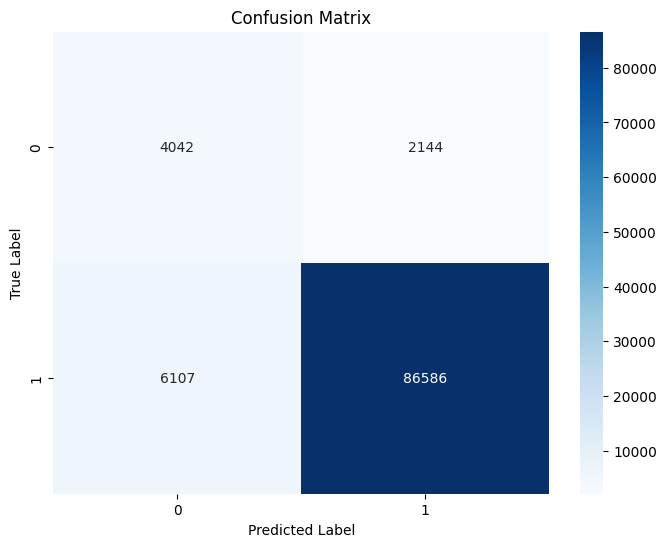

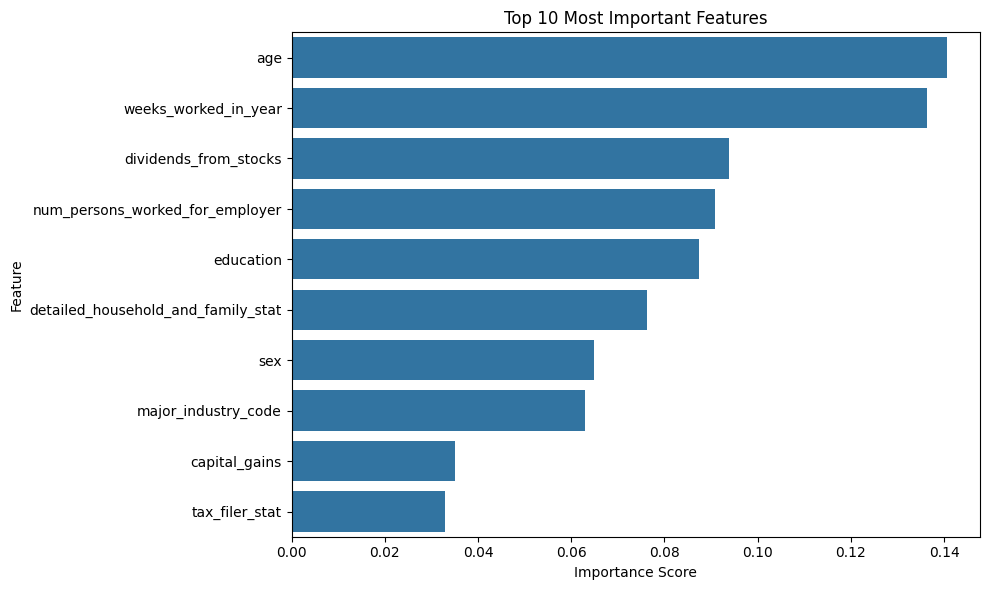

In [15]:
# Train Random Forest Classifier on the resampled data
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)

# Make predictions
y_pred = rfc.predict(X_test_encoded)
y_pred_proba = rfc.predict_proba(X_test_encoded)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_resampled.columns,
    'importance': rfc.feature_importances_
}).sort_values('importance', ascending=False)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10),
            x='importance',
            y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from postprocessing import post_processing

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= True)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= True)
print(f'X_test shape: {X_test.shape}')

# export csv


Train data: ###############################
Number of numeric columns: 8
Original shape: (196294, 28)
Binary shape: (196294, 99)
X_train shape: (196294, 86)

Test data: ###############################
Number of numeric columns: 8
Original shape: (98879, 28)
Binary shape: (98879, 99)
X_test shape: (98879, 86)


In [24]:
# LIGHTGBM Classifier no over sampling

import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np

# Create dataset for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for binary classification
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
num_rounds = 100
model = lgb.train(
    params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    # early_stopping_rounds=20,
    # verbose_eval=10
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Model Evaluation:
-----------------
Accuracy: 0.9551
ROC AUC: 0.9490

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.54      6186
           1       0.96      0.99      0.98     92693

    accuracy                           0.96     98879
   macro avg       0.86      0.71      0.76     98879
weighted avg       0.95      0.96      0.95     98879


Top 10 Most Important Features:
                            feature  importance
2                     capital_gains         337
0                               age         288
3                    capital_losses         282
4             dividends_from_stocks         271
5   num_persons_worked_for_employer         169
1                     wage_per_hour         168
50                        sex__male         121
6              weeks_worked_in_year         109
11        education_advanced_degree          98
10    class_of_worker_self-employed          87


In [23]:
# LIGHTGBM Classifier with over sampling SMOOTENC
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np

# Create dataset for LightGBM using resampled data
train_data = lgb.Dataset(X_resampled, y_resampled)
test_data = lgb.Dataset(X_test_encoded, y_test, reference=train_data)

# Set parameters for binary classification
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
num_rounds = 100
model = lgb.train(
    params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test_encoded)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



Model Evaluation:
-----------------
Accuracy: 0.8745
ROC AUC: 0.9407

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.85      0.46      6186
           1       0.99      0.88      0.93     92693

    accuracy                           0.87     98879
   macro avg       0.65      0.86      0.69     98879
weighted avg       0.95      0.87      0.90     98879


Top 10 Most Important Features:
                            feature  importance
8                         education         427
11              major_industry_code         297
0                               age         247
2                     capital_gains         233
4             dividends_from_stocks         209
6              weeks_worked_in_year         180
5   num_persons_worked_for_employer         160
13                              sex         156
12                             race         132
1                     wage_per_hour         124


Model Evaluation:
-----------------
Accuracy: 0.9298

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.48      0.46      6186
           1       0.97      0.96      0.96     92693

    accuracy                           0.93     98879
   macro avg       0.70      0.72      0.71     98879
weighted avg       0.93      0.93      0.93     98879



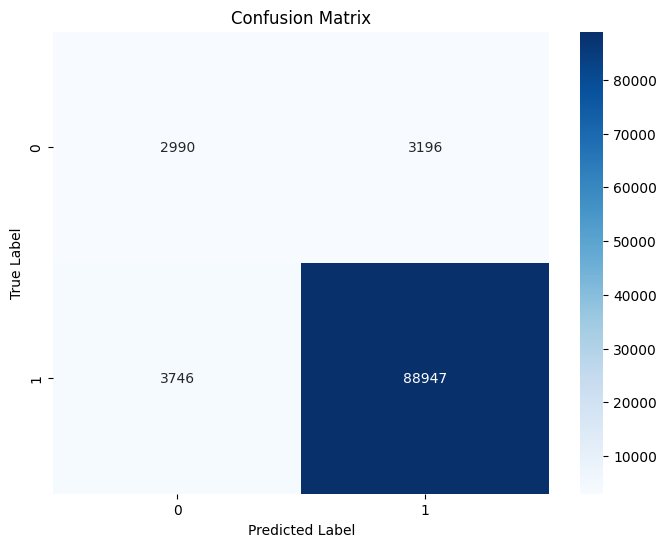

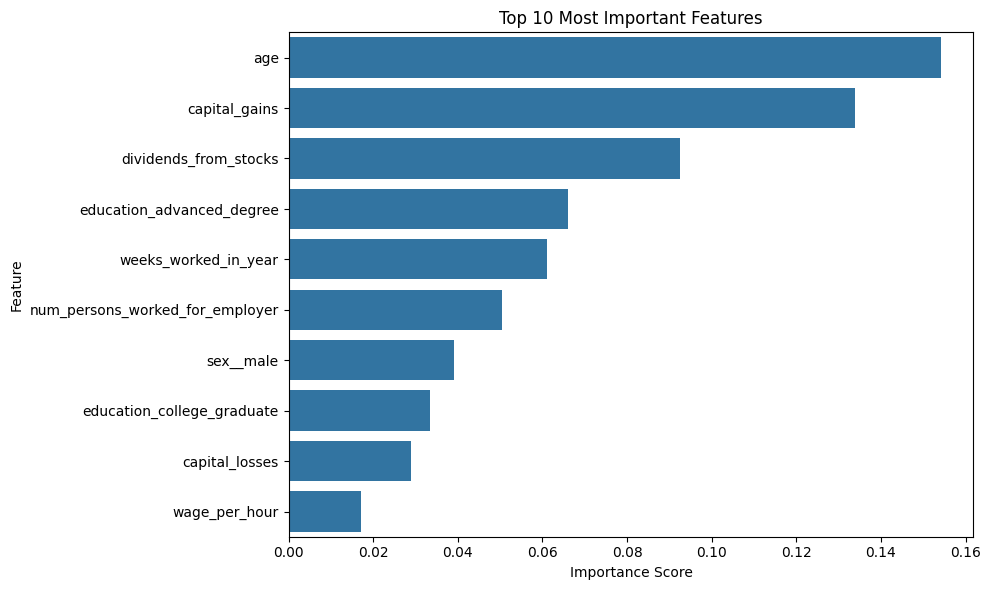

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train, y_train)

# Make predictions
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

# Print model evaluation metrics
print("Model Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10),
            x='importance',
            y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
from postprocessing import post_processing

train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= True)
X_train = X_train.astype(int)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= True)
X_test = X_test.astype(int)
print(f'X_test shape: {X_test.shape}')


Train data: ###############################
Number of numeric columns: 8
Original shape: (143468, 28)
Binary shape: (143468, 93)
X_train shape: (143468, 82)

Test data: ###############################
Number of numeric columns: 8
Original shape: (72023, 28)
Binary shape: (72023, 93)
X_test shape: (72023, 82)


In [2]:
# Under Sampling with One Sided Selection

from imblearn.under_sampling import OneSidedSelection
from collections import Counter

# Initialize OSS
oss = OneSidedSelection(random_state=42)

# Apply OSS
X_train_oss, y_train_oss = oss.fit_resample(X_train, y_train)

# Print class distribution before and after OSS
print("Original class distribution:")
print(Counter(y_train))
print("\nResampled class distribution after OSS:")
print(Counter(y_train_oss))


KeyboardInterrupt: 


Model Evaluation:
-----------------
Accuracy: 0.9384
ROC AUC: 0.9280

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.43      0.55      6186
           1       0.95      0.99      0.97     65837

    accuracy                           0.94     72023
   macro avg       0.85      0.71      0.76     72023
weighted avg       0.93      0.94      0.93     72023


Top 10 Most Important Features:
                            feature  importance
2                     capital_gains         336
0                               age         286
3                    capital_losses         274
4             dividends_from_stocks         274
5   num_persons_worked_for_employer         194
1                     wage_per_hour         155
50                        sex__male         140
6              weeks_worked_in_year         117
11        education_advanced_degree          86
12      education_below_high_school          80
28   major_industr

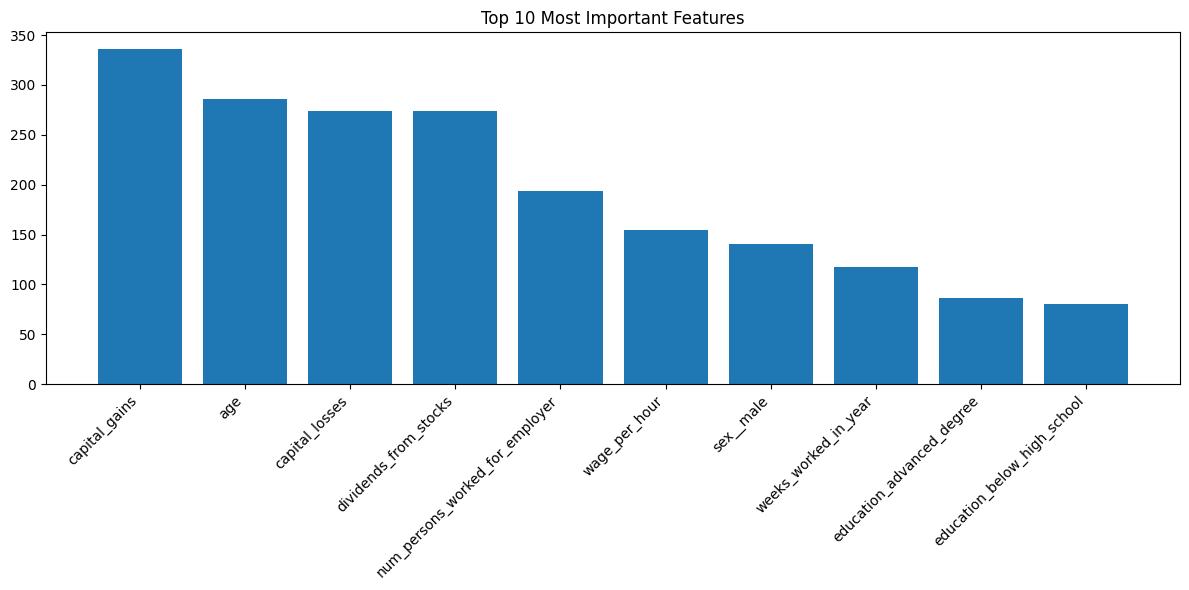


Feature Correlation Analysis:
                             capital_gains        age  capital_losses  \
correlation_with_prediction      -0.341230  -0.033627       -0.185227   
mean_value_when_predicted_1     165.369134  44.587765       35.842221   
mean_value_when_predicted_0    8678.915898  47.328863      299.251187   

                             dividends_from_stocks  \
correlation_with_prediction              -0.227226   
mean_value_when_predicted_1             153.753156   
mean_value_when_predicted_0            2415.248673   

                             num_persons_worked_for_employer  
correlation_with_prediction                        -0.166298  
mean_value_when_predicted_1                         2.547338  
mean_value_when_predicted_0                         4.383068  
--------------------

Detailed Model Performance Metrics:
Accuracy: 0.9384
True Positive Rate: 0.9861
True Negative Rate: 0.4306
Positive Predictive Value: 0.9485


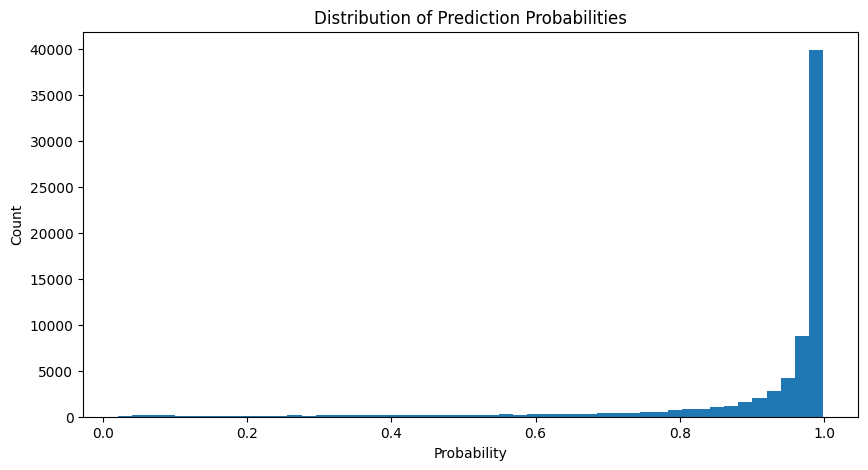

{'fpr': array([0.        , 0.        , 0.        , ..., 0.99612027, 0.99644358,
       1.        ]), 'tpr': array([0.00000000e+00, 3.18969576e-04, 3.49347631e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}


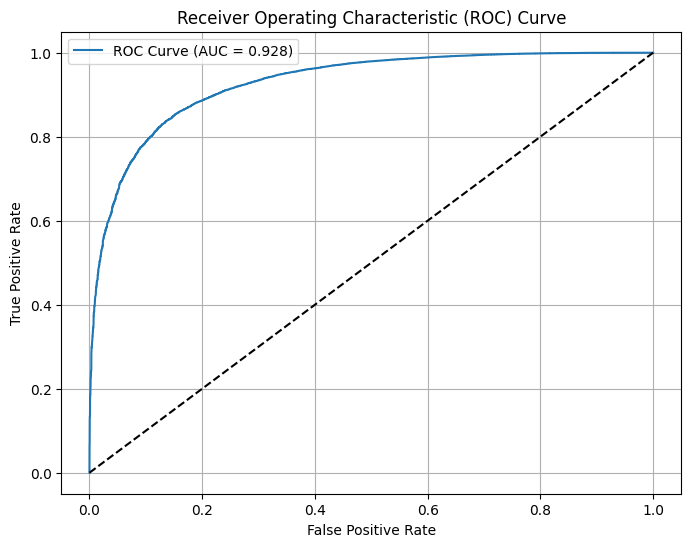


Model Configuration:
--------------------
Number of training rounds: 100

Model Parameters:
objective: binary
metric: binary_logloss
boosting_type: gbdt
num_leaves: 31
learning_rate: 0.05
feature_fraction: 0.9
bagging_fraction: 0.8
bagging_freq: 5
verbose: 0

Class Distribution in Training Data:
Class counts: 
target
1    131088
0     12380
Name: count, dtype: int64
Class proportions: 
target
1    0.913709
0    0.086291
Name: proportion, dtype: float64

Training History:
----------------
train: OrderedDict({'binary_logloss': 0.1601933680324994})
valid: OrderedDict({'binary_logloss': 0.16223992502814666})

Feature Importance Percentages (Top 10):
                            feature  importance_percentage
2                     capital_gains                  11.20
0                               age                   9.53
3                    capital_losses                   9.13
4             dividends_from_stocks                   9.13
5   num_persons_worked_for_employer               

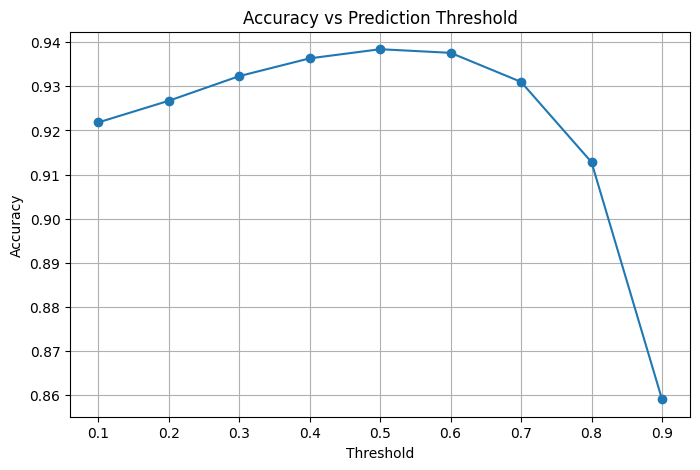


Model Complexity Analysis:
Number of trees: 100
Total number of leaves: 3100

Prediction Confidence Analysis:
                      actual          
                       count      mean
prediction_confidence                 
(0.0208, 0.0869]         480  0.020833
(0.0869, 0.152]          357  0.078431
(0.152, 0.217]           275  0.101818
(0.217, 0.282]           412  0.179612
(0.282, 0.347]           490  0.273469
(0.347, 0.412]           626  0.354633
(0.412, 0.477]           668  0.437126
(0.477, 0.543]           782  0.482097
(0.543, 0.608]           788  0.548223
(0.608, 0.673]           972  0.652263
(0.673, 0.738]          1249  0.702962
(0.738, 0.803]          1831  0.785909
(0.803, 0.868]          3054  0.835298
(0.868, 0.933]          6144  0.902995
(0.933, 0.998]         53895  0.986919


C:\Users\Amin\AppData\Local\Temp\ipykernel_2896\2961422259.py:183: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('prediction_confidence').agg({


In [16]:
# Create dataset for LightGBM using OSS resampled data
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import numpy as np
import matplotlib.pyplot as plt

train_data = lgb.Dataset(X_train, y_train) # (X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Set parameters for binary classification
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
num_rounds = 100
model = lgb.train(
    params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(15))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('confusion_matrix:')
print(cm)
print("--------------------")
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"True Negatives (TN): {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
print("\nConfusion Matrix Percentages:")
print("-------------------------")
print(f"True Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
print(f"False Positives (FP): {(cm[0][1]/total)*100:.2f}%")
print(f"False Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
print(f"True Positives (TP): {(cm[1][1]/total)*100:.2f}%")

# Plot and analyze feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

# Analyze correlation between top features and predictions
top_features = feature_importance['feature'][:5].tolist()
correlations = pd.DataFrame()
for feature in top_features:
    correlations[feature] = pd.Series({
        'correlation_with_prediction': np.corrcoef(X_test[feature], y_pred)[0,1],
        'mean_value_when_predicted_1': X_test[feature][y_pred == 1].mean(),
        'mean_value_when_predicted_0': X_test[feature][y_pred == 0].mean()
    })

print("\nFeature Correlation Analysis:")
print(correlations)
print("--------------------")

# Model performance metrics
print("\nDetailed Model Performance Metrics:")
print(f"Accuracy: {np.mean(y_pred == y_test):.4f}")
print(f"True Positive Rate: {cm[1,1] / (cm[1,0] + cm[1,1]):.4f}")
print(f"True Negative Rate: {cm[0,0] / (cm[0,0] + cm[0,1]):.4f}")
print(f"Positive Predictive Value: {cm[1,1] / (cm[0,1] + cm[1,1]):.4f}")

# Distribution of probabilities
plt.figure(figsize=(10, 5))
plt.hist(y_pred_proba, bins=50)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_curve = {'fpr' : fpr, 'tpr' : tpr}
print(roc_curve)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Additional model insights
print("\nModel Configuration:")
print("--------------------")
print(f"Number of training rounds: {num_rounds}")
print("\nModel Parameters:")
for key, value in params.items():
    print(f"{key}: {value}")

# Training data balance analysis
print("\nClass Distribution in Training Data:")
print(f"Class counts: \n{y_train.value_counts()}")
print(f"Class proportions: \n{y_train.value_counts(normalize=True)}")
# Print model's training history
print("\nTraining History:")
print("----------------")
evals_result = {}
for metric, values in model.best_score.items():
    print(f"{metric}: {values}")

# Feature importance percentages
total_importance = feature_importance['importance'].sum()
feature_importance['importance_percentage'] = (feature_importance['importance'] / total_importance * 100).round(2)
print("\nFeature Importance Percentages (Top 10):")
print(feature_importance[['feature', 'importance_percentage']].head(15))

# Calculate prediction threshold analysis
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    threshold_metrics.append({'threshold': thresh, 'accuracy': acc})

threshold_df = pd.DataFrame(threshold_metrics)
print("\nPrediction Threshold Analysis:")
print(threshold_df)

# Plot threshold analysis
plt.figure(figsize=(8, 5))
plt.plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prediction Threshold')
plt.grid(True)
plt.show()

# Model complexity analysis
print("\nModel Complexity Analysis:")
print(f"Number of trees: {model.num_trees()}")
print(f"Total number of leaves: {model.num_trees() * params['num_leaves']}")

# Analyze prediction confidence
confidence_bins = pd.cut(y_pred_proba, bins=15)
confidence_analysis = pd.DataFrame({
    'prediction_confidence': confidence_bins,
    'actual': y_test
}).groupby('prediction_confidence').agg({
    'actual': ['count', 'mean']
})

print("\nPrediction Confidence Analysis:")
print(confidence_analysis)

In [33]:
## LightGBM Classifier with Optuna Hyperparameter Tuning

import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Create dataset for LightGBM using OSS resampled data
train_data = lgb.Dataset(X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': 0
    }
    
    # Train model with current parameters
    model = lgb.train(
        params,
        train_data,
        num_rounds,
        valid_sets=[test_data],
        # early_stopping_rounds=20,
        # verbose_eval=False
    )
    
    # Get validation score
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': 0
})

print("Best parameters found:", best_params)

# Train final model with best parameters
num_rounds = 100
model = lgb.train(
    best_params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"True Negatives (TN): {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
print("\nConfusion Matrix Percentages:")
print("-------------------------")
print(f"True Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
print(f"False Positives (FP): {(cm[0][1]/total)*100:.2f}%")
print(f"False Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
print(f"True Positives (TP): {(cm[1][1]/total)*100:.2f}%")

[I 2025-01-21 12:43:23,521] A new study created in memory with name: no-name-f005ce4c-0b95-42db-9fca-b41bcb81297c
[I 2025-01-21 12:43:25,943] Trial 0 finished with value: 0.9292357612112223 and parameters: {'num_leaves': 65, 'learning_rate': 0.037480782535249994, 'feature_fraction': 0.6774145883137932, 'bagging_fraction': 0.8914472559600606, 'bagging_freq': 4}. Best is trial 0 with value: 0.9292357612112223.
[I 2025-01-21 12:43:28,031] Trial 1 finished with value: 0.9315251645722286 and parameters: {'num_leaves': 94, 'learning_rate': 0.09218295284615394, 'feature_fraction': 0.4022886123572603, 'bagging_fraction': 0.5878456105964964, 'bagging_freq': 6}. Best is trial 1 with value: 0.9315251645722286.
[I 2025-01-21 12:43:30,061] Trial 2 finished with value: 0.9309761718338359 and parameters: {'num_leaves': 111, 'learning_rate': 0.04903114185507075, 'feature_fraction': 0.6012060783171269, 'bagging_fraction': 0.49526791652137997, 'bagging_freq': 3}. Best is trial 1 with value: 0.9315251645

Best parameters found: {'num_leaves': 127, 'learning_rate': 0.09607934832199024, 'feature_fraction': 0.4574741070603503, 'bagging_fraction': 0.9773115863056199, 'bagging_freq': 2, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbose': 0}

Model Evaluation:
-----------------
Accuracy: 0.9404
ROC AUC: 0.9335

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.49      0.59      6186
           1       0.95      0.98      0.97     65837

    accuracy                           0.94     72023
   macro avg       0.84      0.74      0.78     72023
weighted avg       0.93      0.94      0.94     72023


Top 10 Most Important Features:
                                  feature  importance
0                                     age        1621
4                   dividends_from_stocks        1157
5         num_persons_worked_for_employer         772
2                           capital_gains         761
6     

In [39]:
y_test.reset_index(drop= True)

0        1
1        1
2        1
3        1
4        1
        ..
72018    1
72019    1
72020    1
72021    1
72022    1
Name: target, Length: 72023, dtype: int64

In [40]:
# False Positive Analysis
print(y_pred.shape)
print(y_test.shape)
print(X_test.shape)

FP = X_test.reset_index()
FP['y_pred'] = y_pred
FP['y_true'] = y_test.reset_index(drop=True)

(72023,)
(72023,)
(72023, 82)


In [ ]:
# cross validate
FP[(FP['y_pred'] == 1) & (FP['y_true'] == 0)]['y_pred'].value_counts()

y_pred
1.0    3137
Name: count, dtype: int64

In [79]:
FP1 = FP[(FP['y_pred'] == 1)]

NameError: name '__file__' is not defined

In [46]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [60]:
def join_binary_columns(df, prefix, sep='_'):
    """
    Combines binary columns back into a single categorical column.
    Example: columns ['color_red', 'color_blue'] -> 'color' column with values ['red', 'blue']
    """
    # Get relevant columns
    cols = [c for c in df.columns if c.startswith(prefix + sep)]
    
    # For each row, get the category name where value is 1
    categories = [c.replace(prefix + sep, '') for c in cols]
    return pd.Series([categories[row.values.argmax()] for _, row in df[cols].iterrows()])

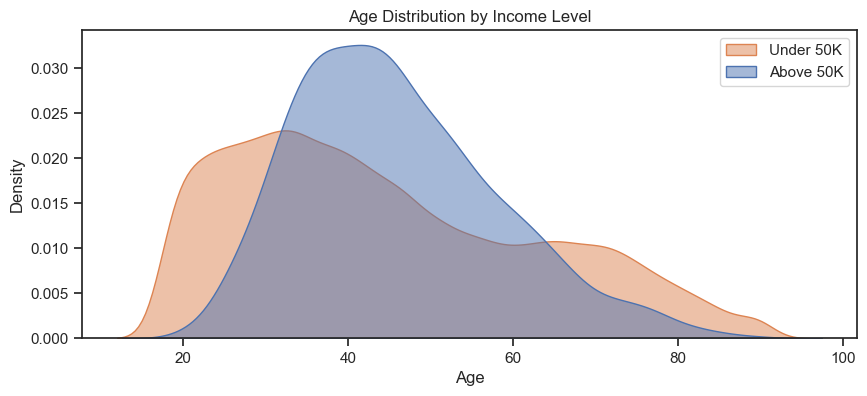

In [58]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 4))
sns.kdeplot(data= FP1, x='age',hue= 'y_true' ,fill=True, alpha=0.5, common_norm=False)
plt.title('Age Distribution by Income Level')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(labels=['Under 50K', 'Above 50K'])

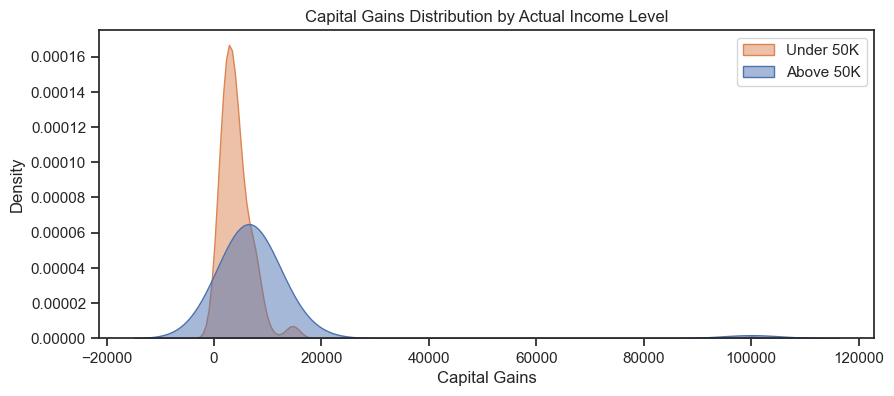

In [57]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 4))
sns.kdeplot(data=FP1[FP1['capital_gains'] > 0], 
            x='capital_gains', 
            hue='y_true', 
            common_norm=False,  # Normalize each distribution separately
            fill=True, 
            alpha=0.5)
plt.title('Capital Gains Distribution by Actual Income Level')
plt.xlabel('Capital Gains')
plt.ylabel('Density')
plt.legend(labels=['Under 50K', 'Above 50K'])

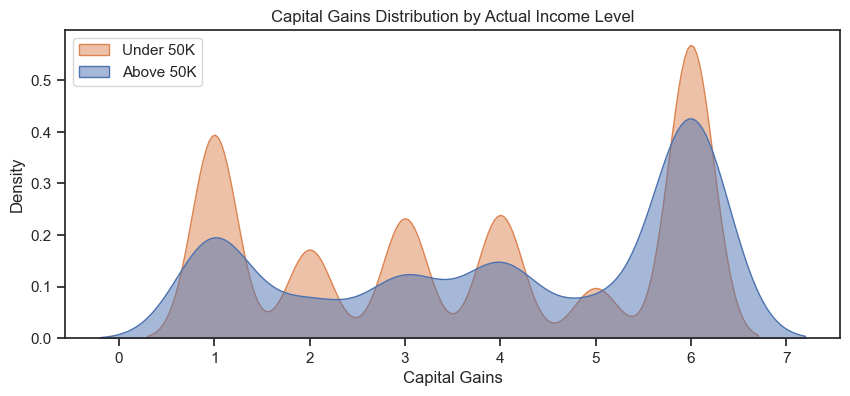

In [59]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 4))
sns.kdeplot(data=FP1[FP1['num_persons_worked_for_employer'] > 0], 
            x='num_persons_worked_for_employer', 
            hue='y_true', 
            common_norm=False,  # Normalize each distribution separately
            fill=True, 
            alpha=0.5)
plt.title('Capital Gains Distribution by Actual Income Level')
plt.xlabel('Capital Gains')
plt.ylabel('Density')
plt.legend(labels=['Under 50K', 'Above 50K'])

In [80]:
FP1['race'] = join_binary_columns(FP1, 'race_')
FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
FP1['major_industry_code_'] = join_binary_columns(FP1, 'major_industry_code_')
FP1['education'] = join_binary_columns(FP1, 'education')
FP1['enroll_in_edu_inst_last_wk_'] = join_binary_columns(FP1, 'enroll_in_edu_inst_last_wk_')
FP1['full_or_part_time_employment_stat'] = join_binary_columns(FP1, 'full_or_part_time_employment_stat')
FP1['live_in_this_house_1_year_ago_'] = join_binary_columns(FP1, 'live_in_this_house_1_year_ago_')
FP1['marital_stat_'] = join_binary_columns(FP1, 'marital_stat')
FP1['reason_for_unemployment'] = join_binary_columns(FP1, 'reason_for_unemployment')
FP1['migration_prev_res_in_sunbelt'] = join_binary_columns(FP1, 'migration_prev_res_in_sunbelt_')
FP1['citizenship'] = join_binary_columns(FP1, 'citizenship')
FP1['own_business_or_self_employed'] = join_binary_columns(FP1, 'own_business_or_self_employed')
FP1['region_of_previous_residence'] = join_binary_columns(FP1, 'region_of_previous_residence_')

C:\Users\Amin\AppData\Local\Temp\ipykernel_12904\1925839199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['race'] = join_binary_columns(FP1, 'race_')
C:\Users\Amin\AppData\Local\Temp\ipykernel_12904\1925839199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FP1['class_of_worker'] = join_binary_columns(FP1, 'class_of_worker')
C:\Users\Amin\AppData\Local\Temp\ipykernel_12904\1925839199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

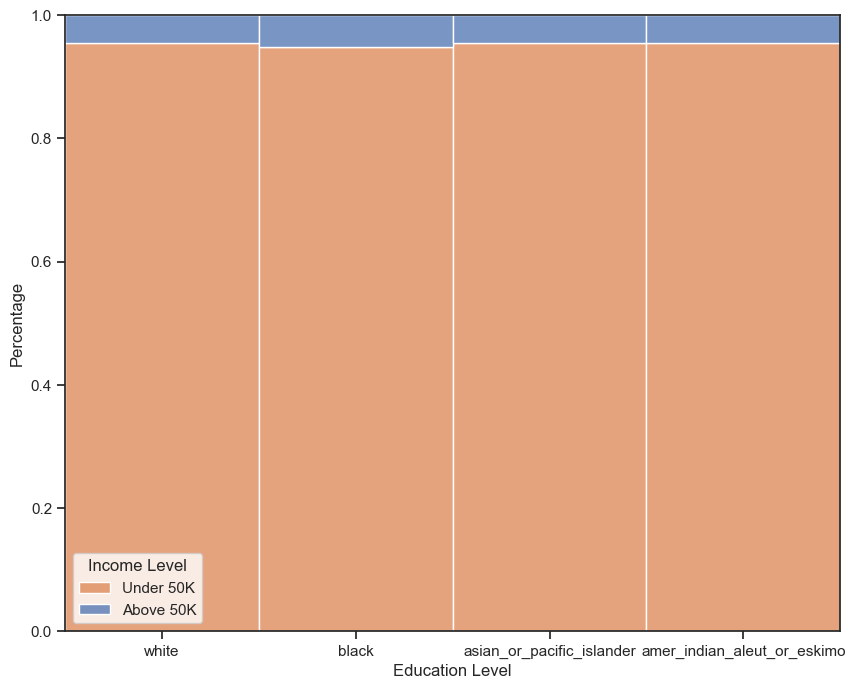

In [68]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='race', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')

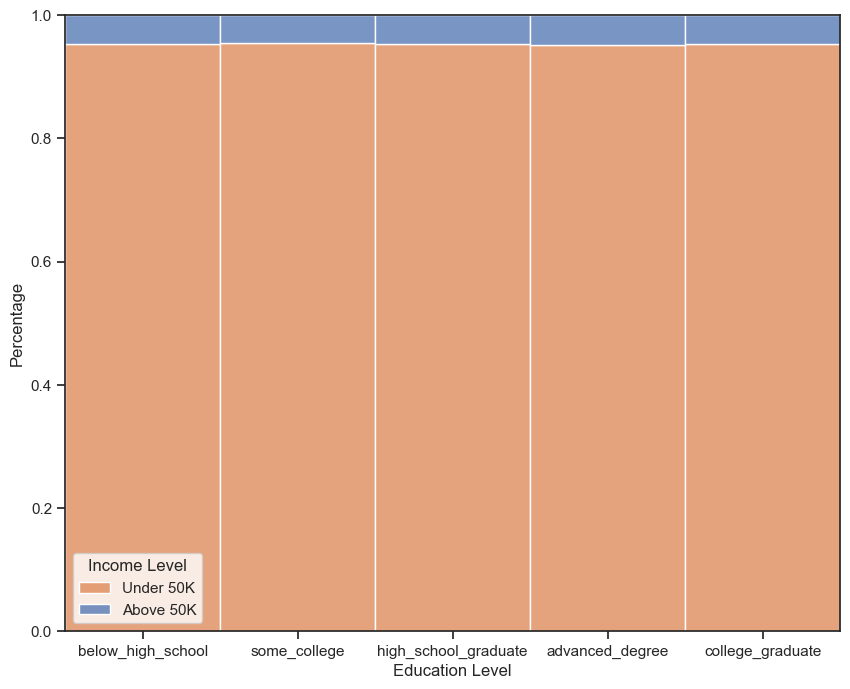

In [69]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='education', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')

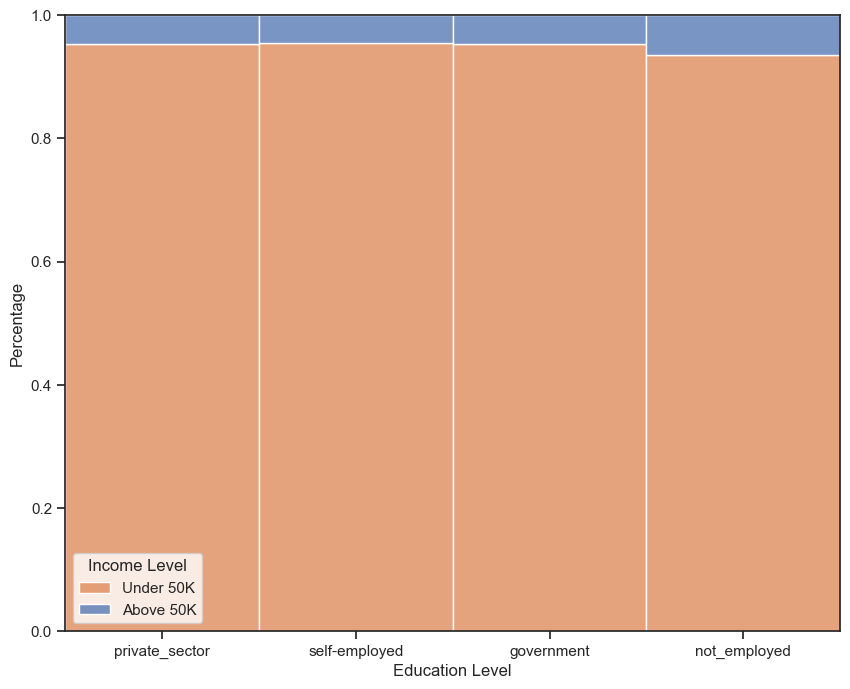

In [71]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='class_of_worker', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'manufacturing-durable_goods'),
  Text(1, 0, 'business_and_repair_services'),
  Text(2, 0, 'transportation'),
  Text(3, 0, 'construction'),
  Text(4, 0, 'agriculture'),
  Text(5, 0, 'other_professional_services'),
  Text(6, 0, 'private_household_services'),
  Text(7, 0, 'retail_trade'),
  Text(8, 0, 'entertainment'),
  Text(9, 0, 'public_administration'),
  Text(10, 0, 'manufacturing-nondurable_goods'),
  Text(11, 0, 'finance_insurance_and_real_estate'),
  Text(12, 0, 'education'),
  Text(13, 0, 'personal_services_except_private_hh'),
  Text(14, 0, 'medical_except_hospital'),
  Text(15, 0, 'hospital_services'),
  Text(16, 0, 'wholesale_trade'),
  Text(17, 0, 'utilities_and_sanitary_services'),
  Text(18, 0, 'social_services'),
  Text(19, 0, 'communications'),
  Text(20, 0, 'mining'),
  Text(21, 0, 'forestry_and_fisheries'),
  Text(22, 0, 'armed_f

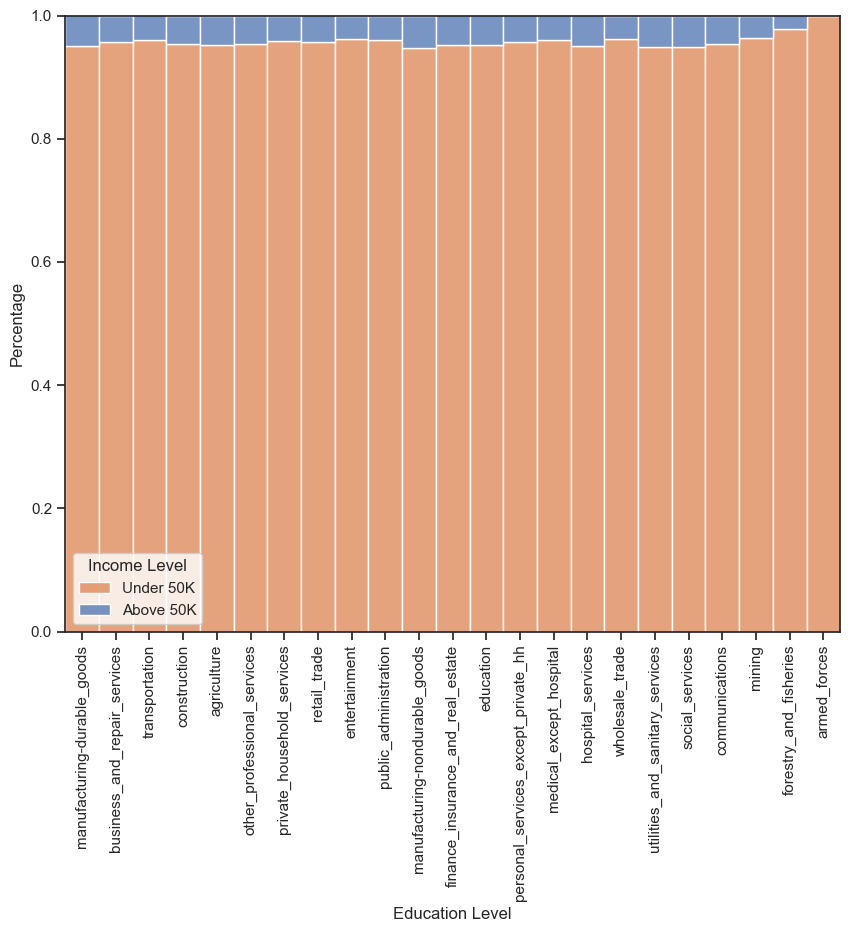

In [73]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='major_industry_code_', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1], [Text(0, 0, 'college_or_university'), Text(1, 0, 'high_school')])

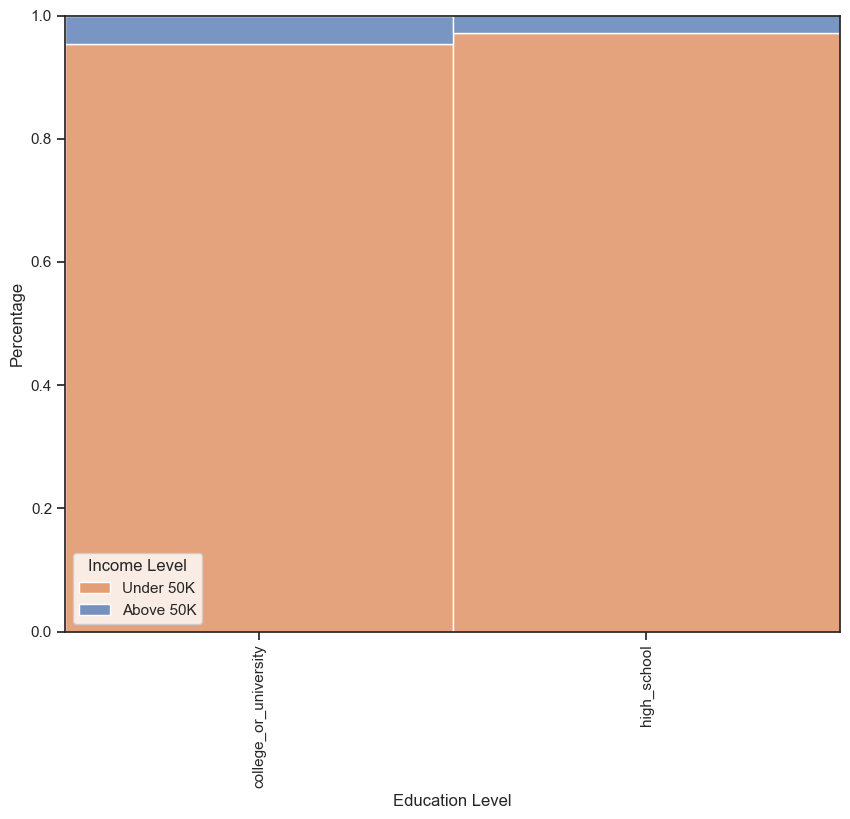

In [74]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='enroll_in_edu_inst_last_wk_', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'married'),
  Text(1, 0, 'divorced'),
  Text(2, 0, 'never_married'),
  Text(3, 0, 'widowed'),
  Text(4, 0, 'separated')])

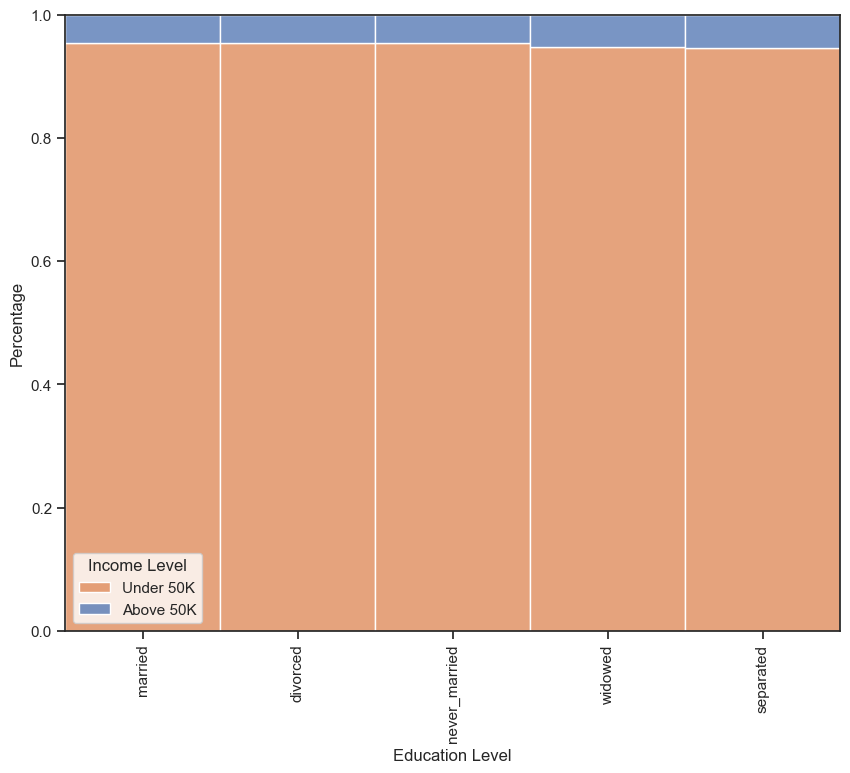

In [77]:

sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='marital_stat_', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1, 2, 3],
 [Text(0, 0, 'job_leaver'),
  Text(1, 0, 're-entrant'),
  Text(2, 0, 'job_loser'),
  Text(3, 0, 'new_entrant')])

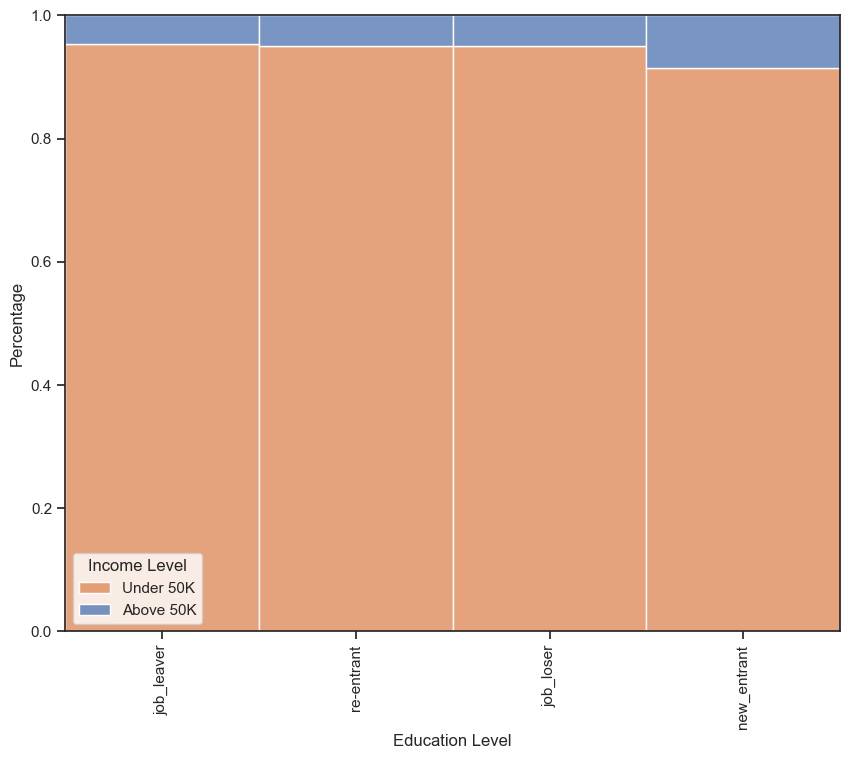

In [81]:

sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='reason_for_unemployment', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1], [Text(0, 0, 'no'), Text(1, 0, 'yes')])

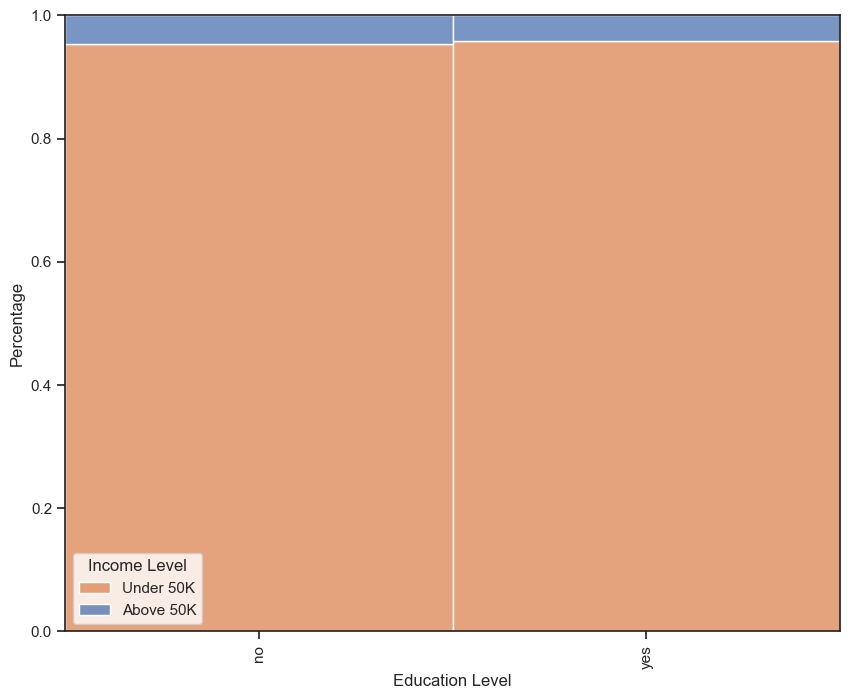

In [82]:

sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='migration_prev_res_in_sunbelt', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1], [Text(0, 0, 'no'), Text(1, 0, 'yes')])

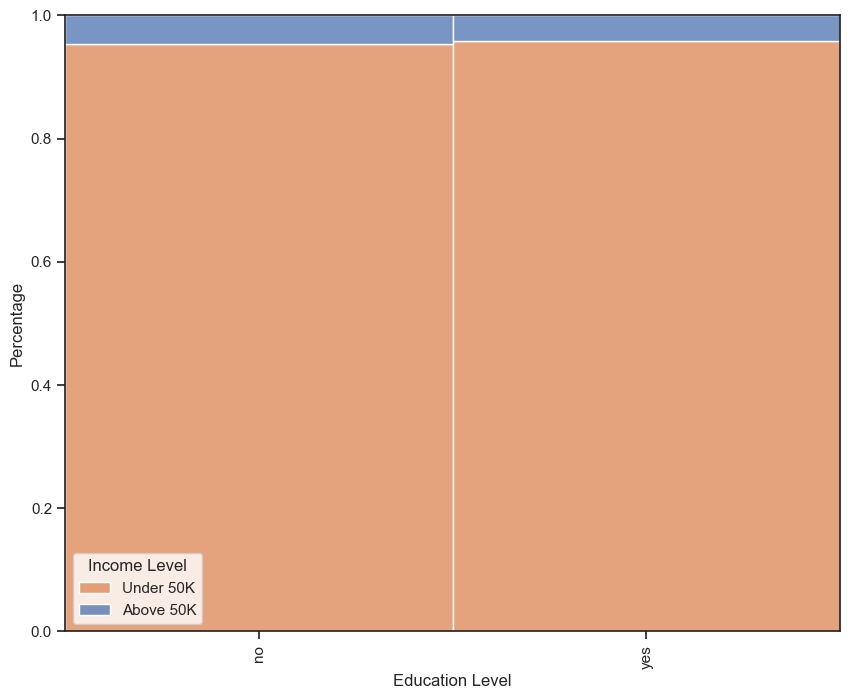

In [84]:

sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='own_business_or_self_employed', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1], [Text(0, 0, 'foreign'), Text(1, 0, 'native')])

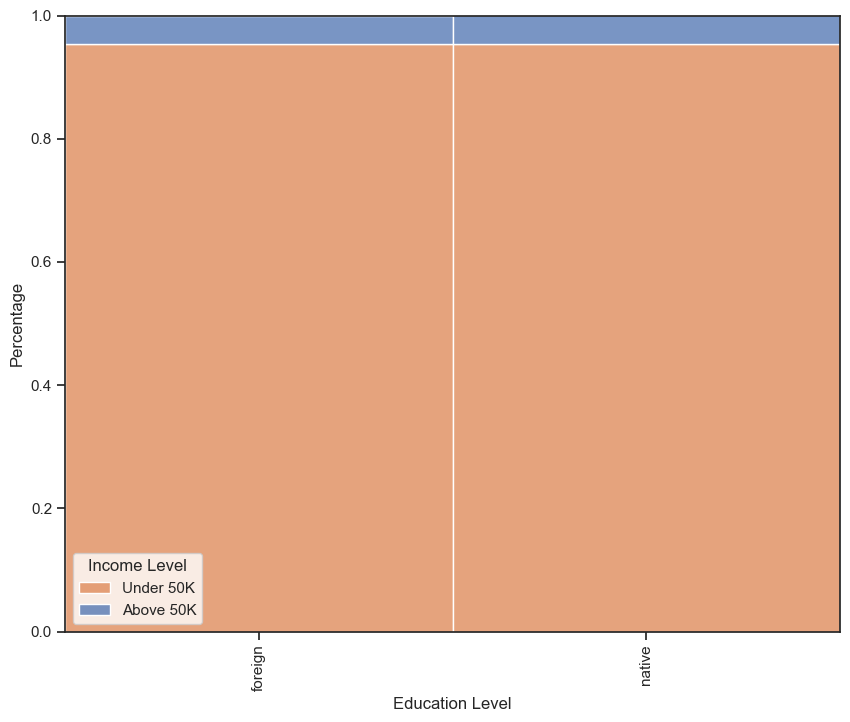

In [83]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='citizenship', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'abroad'),
  Text(1, 0, 'northeast'),
  Text(2, 0, 'midwest'),
  Text(3, 0, 'south'),
  Text(4, 0, 'west')])

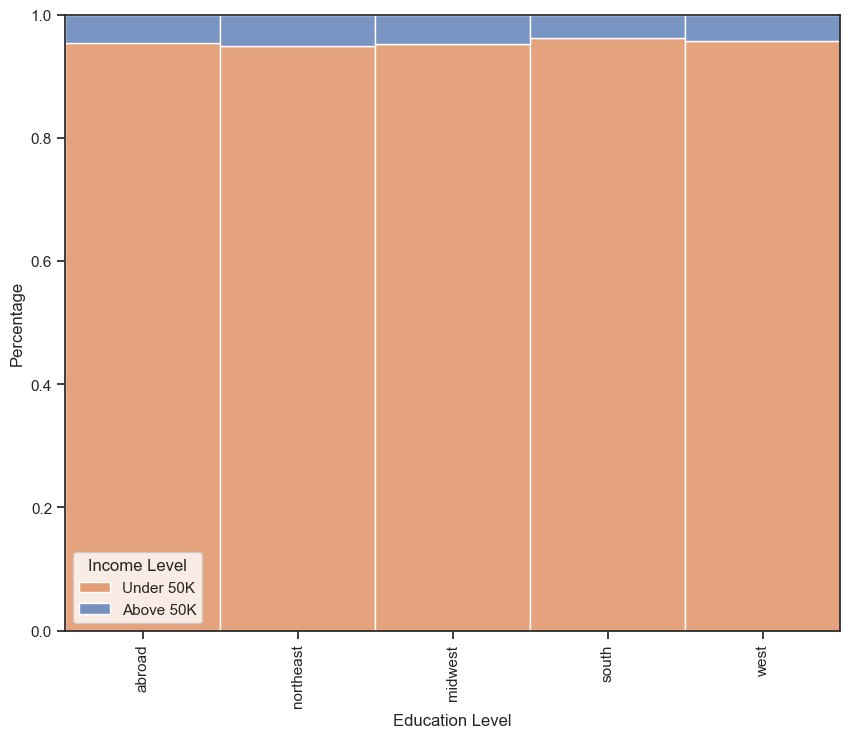

In [85]:
sns.set_theme(style="ticks")  # Set the theme
plt.figure(figsize=(10, 8))
sns.histplot(data=FP1, x='region_of_previous_residence', hue='y_true', stat='percent', multiple="fill")
# plt.title('Education Distribution by Income Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
plt.xticks(rotation=90)

In [53]:
FP1.columns

Index(['index', 'age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'num_persons_worked_for_employer',
       'weeks_worked_in_year', 'class_of_worker_government',
       'class_of_worker_not_employed', 'class_of_worker_private_sector',
       'class_of_worker_self-employed', 'education_advanced_degree',
       'education_below_high_school', 'education_college_graduate',
       'education_high_school_graduate', 'education_some_college',
       'enroll_in_edu_inst_last_wk__college_or_university',
       'enroll_in_edu_inst_last_wk__high_school', 'marital_stat_divorced',
       'marital_stat_married', 'marital_stat_never_married',
       'marital_stat_separated', 'marital_stat_widowed',
       'major_industry_code__agriculture', 'major_industry_code__armed_forces',
       'major_industry_code__business_and_repair_services',
       'major_industry_code__communications',
       'major_industry_code__construction', 'major_industry_code__education',
   

In [9]:
## LightGBM Classifier with Optuna Hyperparameter Tuning, Nparam = 150

import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Create dataset for LightGBM using OSS resampled data
train_data = lgb.Dataset(X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': 0
    }
    
    # Train model with current parameters
    model = lgb.train(
        params,
        train_data,
        num_rounds,
        valid_sets=[test_data],
        # early_stopping_rounds=20,
        # verbose_eval=False
    )
    
    # Get validation score
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': 0
})

print("Best parameters found:", best_params)

# Train final model with best parameters
num_rounds = 150
model = lgb.train(
    best_params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"True Negatives (TN): {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
print("\nConfusion Matrix Percentages:")
print("-------------------------")
print(f"True Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
print(f"False Positives (FP): {(cm[0][1]/total)*100:.2f}%")
print(f"False Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
print(f"True Positives (TP): {(cm[1][1]/total)*100:.2f}%")

[I 2025-01-20 23:18:50,911] A new study created in memory with name: no-name-253867ae-c63a-444b-aa25-399282835839


[I 2025-01-20 23:18:54,128] Trial 0 finished with value: 0.9259799885128133 and parameters: {'num_leaves': 71, 'learning_rate': 0.016802806396054658, 'feature_fraction': 0.5430729651102884, 'bagging_fraction': 0.8806552662785574, 'bagging_freq': 6}. Best is trial 0 with value: 0.9259799885128133.
[I 2025-01-20 23:18:56,949] Trial 1 finished with value: 0.9321169461219365 and parameters: {'num_leaves': 93, 'learning_rate': 0.06456956302676861, 'feature_fraction': 0.8701385581383341, 'bagging_fraction': 0.8501335212625696, 'bagging_freq': 6}. Best is trial 1 with value: 0.9321169461219365.
[I 2025-01-20 23:18:59,029] Trial 2 finished with value: 0.9303490167432437 and parameters: {'num_leaves': 42, 'learning_rate': 0.05765880133579147, 'feature_fraction': 0.5708162717420526, 'bagging_fraction': 0.9943021320220559, 'bagging_freq': 2}. Best is trial 1 with value: 0.9321169461219365.
[I 2025-01-20 23:19:01,616] Trial 3 finished with value: 0.9296279209799907 and parameters: {'num_leaves': 1

Best parameters found: {'num_leaves': 106, 'learning_rate': 0.09528805174195293, 'feature_fraction': 0.45547992648851476, 'bagging_fraction': 0.8550529146308655, 'bagging_freq': 7, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbose': 0}

Model Evaluation:
-----------------
Accuracy: 0.9402
ROC AUC: 0.9334

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.49      0.59      6186
           1       0.95      0.98      0.97     65837

    accuracy                           0.94     72023
   macro avg       0.84      0.74      0.78     72023
weighted avg       0.93      0.94      0.94     72023


Top 10 Most Important Features:
                                   feature  importance
0                                      age        2221
4                    dividends_from_stocks        1463
5          num_persons_worked_for_employer         916
6                     weeks_worked_in_year         851


In [56]:
## LightGBM Classifier with Optuna Hyperparameter Tuning , NUM ROUND 150

import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Create dataset for LightGBM using OSS resampled data
train_data = lgb.Dataset(X_train_oss, y_train_oss)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'verbose': 0
    }
    
    # Train model with current parameters
    model = lgb.train(
        params,
        train_data,
        num_rounds,
        valid_sets=[test_data],
        # early_stopping_rounds=20,
        # verbose_eval=False
    )
    
    # Get validation score
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'verbose': 0
})

print("Best parameters found:", best_params)

# Train final model with best parameters
num_rounds = 150
model = lgb.train(
    best_params,
    train_data,
    num_rounds,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid']
)

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

# Evaluate model
print("\nModel Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Print confusion matrix values in a tabular format
print("\nConfusion Matrix Values:")
print("--------------------")
print(f"True Negatives (TN): {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP): {cm[1][1]}")

# Calculate and print percentages
total = cm.sum()
print("\nConfusion Matrix Percentages:")
print("-------------------------")
print(f"True Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
print(f"False Positives (FP): {(cm[0][1]/total)*100:.2f}%")
print(f"False Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
print(f"True Positives (TP): {(cm[1][1]/total)*100:.2f}%")

[I 2025-01-20 19:28:44,786] A new study created in memory with name: no-name-823681e1-6bbb-4fb4-b51c-bd3dc513d415
[I 2025-01-20 19:28:48,257] Trial 0 finished with value: 0.952064504142106 and parameters: {'num_leaves': 63, 'learning_rate': 0.05829228093186055, 'feature_fraction': 0.6791151689868359, 'bagging_fraction': 0.7564797937630091, 'bagging_freq': 5}. Best is trial 0 with value: 0.952064504142106.
[I 2025-01-20 19:28:49,913] Trial 1 finished with value: 0.9487302415429475 and parameters: {'num_leaves': 15, 'learning_rate': 0.06181246496996653, 'feature_fraction': 0.5756543672946351, 'bagging_fraction': 0.536150663511491, 'bagging_freq': 6}. Best is trial 0 with value: 0.952064504142106.
[I 2025-01-20 19:28:53,119] Trial 2 finished with value: 0.9502757389324455 and parameters: {'num_leaves': 109, 'learning_rate': 0.027795540888987814, 'feature_fraction': 0.4186583926555131, 'bagging_fraction': 0.5282513635020474, 'bagging_freq': 4}. Best is trial 0 with value: 0.952064504142106

Best parameters found: {'num_leaves': 127, 'learning_rate': 0.0549322655303071, 'feature_fraction': 0.8483494837652042, 'bagging_fraction': 0.9627862636262254, 'bagging_freq': 5, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbose': 0}

Model Evaluation:
-----------------
Accuracy: 0.9565
ROC AUC: 0.9530

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.50      0.59      6186
           1       0.97      0.99      0.98     92693

    accuracy                           0.96     98879
   macro avg       0.84      0.74      0.78     98879
weighted avg       0.95      0.96      0.95     98879


Top 10 Most Important Features:
                            feature  importance
0                               age        4219
4             dividends_from_stocks        2246
5   num_persons_worked_for_employer        1546
6              weeks_worked_in_year        1340
3                    capital_losses  

In [60]:
## Random Forest Classifier with Threshold Adjustment

# Train model with the same parameters
model = RandomForestClassifier(**params)
model.fit(X_train_oss, y_train_oss)

# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = [0.6, 0.7, 0.8]
for threshold in thresholds:
    # Apply threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nResults with threshold {threshold}:")
    print("-" * 30)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix values
    print("\nConfusion Matrix Values:")
    print(f"True Negatives (TN): {cm[0][0]}")
    print(f"False Positives (FP): {cm[0][1]}")
    print(f"False Negatives (FN): {cm[1][0]}")
    print(f"True Positives (TP): {cm[1][1]}")
    
    # Calculate and print percentages
    total = cm.sum()
    print("\nConfusion Matrix Percentages:")
    print(f"True Negatives (TN): {(cm[0][0]/total)*100:.2f}%")
    print(f"False Positives (FP): {(cm[0][1]/total)*100:.2f}%")
    print(f"False Negatives (FN): {(cm[1][0]/total)*100:.2f}%")
    print(f"True Positives (TP): {(cm[1][1]/total)*100:.2f}%")



Results with threshold 0.6:
------------------------------
Accuracy: 0.9535

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      6186
           1       0.97      0.98      0.98     92693

    accuracy                           0.95     98879
   macro avg       0.82      0.74      0.78     98879
weighted avg       0.95      0.95      0.95     98879


Confusion Matrix Values:
True Negatives (TN): 3127
False Positives (FP): 3059
False Negatives (FN): 1543
True Positives (TP): 91150

Confusion Matrix Percentages:
True Negatives (TN): 3.16%
False Positives (FP): 3.09%
False Negatives (FN): 1.56%
True Positives (TP): 92.18%

Results with threshold 0.7:
------------------------------
Accuracy: 0.9479

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.59      6186
           1       0.97      0.97      0.97     92693

    accuracy                    